# 2.0 Feature Selection, Engineering and Analysis

In [124]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import KFold
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# import cleaned data and make it into a pandas Data Frame
with open('json_/cleaned_data_2.json') as json_file:
    data = json.load(json_file)

In [3]:
with open('json_/unseen_data_0.json') as json_file:
    data4 = json.load(json_file)

In [4]:
df = pd.read_json(data)

In [5]:
df4 = pd.read_json(data4)

In [6]:
df.shape

(9121, 25)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9121 entries, 0 to 999
Data columns (total 25 columns):
backers_count               9121 non-null int64
converted_pledged_amount    9121 non-null int64
country                     9121 non-null object
created_at                  9121 non-null datetime64[ns]
currency                    9121 non-null object
current_currency            9121 non-null object
deadline                    9121 non-null int64
disable_communication       9121 non-null bool
fx_rate                     9121 non-null float64
goal                        9121 non-null float64
id                          9121 non-null int64
is_starrable                9121 non-null bool
launched_at                 9121 non-null datetime64[ns]
name                        9121 non-null object
pledged                     9121 non-null float64
spotlight                   9121 non-null bool
staff_pick                  9121 non-null bool
state                       9121 non-null object
state

In [8]:
df.head(1)

,backers_count,converted_pledged_amount,country,created_at,currency,current_currency,deadline,disable_communication,fx_rate,goal,...,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,cat_name,cat_slug,loc_state
0,6,1847,GB,2015-04-03,GBP,USD,1430956800000,False,1.30399,7000.0,...,False,False,canceled,2015-04-19,1.491538,"{""web"":{""project"":""https://www.kickstarter.com...",1842.049134,Ready-to-wear,fashion/ready-to-wear,England


In [9]:
# deadline's date appears to have changed format, as such it is returned to desired format
df['deadline'] = pd.to_datetime(df['deadline'], unit='ms')
df['deadline'] = pd.to_datetime(df['deadline'].dt.date)

In [10]:
# Get names of indexes with states of canceled, live and suspended and remove them as they are
# not an indication of success or failure. Cancellation and suspension could be for various reasons other
# than failure.
indexNames = df[(df['state'] == 'canceled')|(df['state'] == 'live')|(df['state'] == 'suspended')].index
# Delete these row indexes from dataFrame
df.drop(indexNames,0,inplace=True)

In [11]:
# Check data target balance
df['state'].value_counts()

successful    5174
failed        3171
Name: state, dtype: int64

In [12]:
# I would like to convert countries into continents 
df['country'].value_counts();

In [13]:
for index, row in df.iterrows():
    if df.loc[index,'country'] == 'US' or df.loc[index,'country'] == 'CA':
        df.loc[index,'country'] = 'NAmerica'
    elif df.loc[index,'country'] == 'NZ' or df.loc[index,'country'] == 'AU':
        df.loc[index,'country'] = 'Aus'
    elif df.loc[index,'country'] == 'JP' or df.loc[index,'country'] == 'CH' or df.loc[index,'country'] == 'HK' or df.loc[index,'country'] == 'SG':
        df.loc[index,'country'] = 'Aisa'
    elif df.loc[index,'country'] == 'MX':
        df.loc[index,'country'] = 'CAmerica'
    else:
        df.loc[index,'country'] = 'Euro'

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
df.shape

(8345, 25)

#### Create new features

In [16]:
# time_allowed feature is the time between creating the kickstarter project and ending it in days
df['time_allowed'] = df['deadline']-df['created_at']

In [17]:
# which is then converted into an integer
df.time_allowed = df.time_allowed.dt.days

In [18]:
# ratio of funding pledged/goal is used to normalise the date and replace 'goal' and 'pledge' amount
# df['pledge/goal'] = (df['converted_pledged_amount']/df['goal'])

In [19]:
# another ration of goal and time_allowed is attempted
df['goal/time_allowed'] = (df['goal']/df['time_allowed'])

In [20]:
# Below I am inspecting the data to gauge presence of outliers and understand what is the range I am looking at

In [21]:
df.goal.describe();

In [22]:
df.time_allowed.describe()

count    8345.000000
mean       82.278850
std       137.822285
min         3.000000
25%        33.000000
50%        47.000000
75%        73.000000
max      2431.000000
Name: time_allowed, dtype: float64

In [23]:
df['goal/time_allowed'].describe()

count    8.345000e+03
mean     7.158406e+02
std      1.939620e+04
min      1.063830e-02
25%      2.697095e+01
50%      8.108108e+01
75%      2.333333e+02
max      1.612903e+06
Name: goal/time_allowed, dtype: float64

In [24]:
df['goal/time_allowed'].value_counts()

166.666667     87
33.333333      57
16.666667      54
100.000000     53
83.333333      48
50.000000      47
333.333333     46
125.000000     46
142.857143     44
66.666667      42
32.258065      35
62.500000      35
156.250000     34
250.000000     32
161.290323     32
111.111111     32
312.500000     31
151.515152     30
90.909091      30
200.000000     30
500.000000     29
25.000000      29
16.129032      29
20.000000      28
27.777778      28
45.454545      28
55.555556      27
31.250000      27
294.117647     26
322.580645     25
               ..
0.434783        1
105.236842      1
85.937500       1
13.477089       1
23.170732       1
13.414634       1
780.487805      1
52.960526       1
6.038647        1
1311.475410     1
80.213904       1
13.432836       1
265.957447      1
254.545455      1
1.652893        1
127.906977      1
9.202454        1
54.151625       1
2.586207        1
5.434783        1
22.026432       1
42.746114       1
947.368421      1
181.159420      1
12.833333 

In [25]:
outlier_plot_data = df[(df['time_allowed'] < 5000) & (df['goal'] < 2e6)]

In [26]:
len(outlier_plot_data)-df.shape[0]

-12

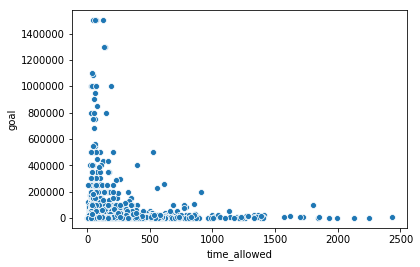

In [46]:
sns_plot = sns.scatterplot('time_allowed', 'goal',data=outlier_plot_data)
# plt.savefig('plot_downloads/scatter1.png')

In [47]:
# (df[df['goal/time_allowed'] > 4.5].index)|
outliers_index = list(df[df['time_allowed'] > 2500].index)+list(df[df['goal'] > 2e6].index)

In [48]:
len(outliers_index)

0

In [49]:
df.drop(outliers_index,0,inplace=True)

In [50]:
df.reset_index(drop=True, inplace=True)

In [51]:
df.shape

(8334, 27)

In [52]:
df['log_goal'] = np.log(df['goal'])
df['log_time_allowed'] = np.log(df['time_allowed'])

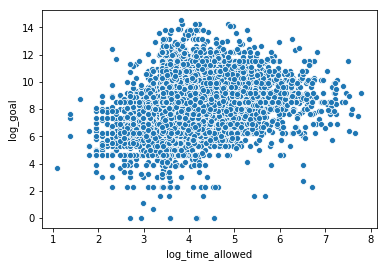

In [54]:
sns.scatterplot('log_time_allowed', 'log_goal',data=df)
# plt.savefig('plot_downloads/scatter2.png')

In [ ]:
# df.to_csv(r'df_df+log.csv')

In [55]:
# df['pledge/goal'].describe()

In [56]:
# plt.hist(df['pledge/goal'], bins=10)


In [57]:
# # binning pledge/goal ration into bins
# bins = [-0.01, 0.5, 1.0 , 1.5, 2.0, 2.5, 3.0, 5.0]
# bins_pledgeGoal = pd.cut(df['pledge/goal'], bins)
# bins_pledgeGoal = bins_pledgeGoal.cat.as_ordered()
# df["pledge/goal"]=bins_pledgeGoal
# df["pledge/goal"];

In [58]:
# df.isna().sum().sum()

In [59]:
# Pick contineous features

In [60]:
X_c = df[['log_time_allowed', 'log_goal']]

In [61]:
# X_c.to_csv(r'csv_\X_c.csv')

In [62]:
# Pick categotical features

In [63]:
X_d = pd.get_dummies(df[['cat_slug', 'staff_pick', 'country']], drop_first=True, prefix_sep='_')

In [64]:
X_d.columns

Index(['staff_pick', 'cat_slug_art/ceramics', 'cat_slug_art/conceptual art',
       'cat_slug_art/digital art', 'cat_slug_art/illustration',
       'cat_slug_art/installations', 'cat_slug_art/mixed media',
       'cat_slug_art/painting', 'cat_slug_art/performance art',
       'cat_slug_art/public art',
       ...
       'cat_slug_theater/experimental', 'cat_slug_theater/festivals',
       'cat_slug_theater/immersive', 'cat_slug_theater/musical',
       'cat_slug_theater/plays', 'cat_slug_theater/spaces', 'country_Aus',
       'country_CAmerica', 'country_Euro', 'country_NAmerica'],
      dtype='object', length=172)

In [65]:
# rename 'pledge/goal_...' as they pose issues when running models

In [66]:
# X_d.rename(columns={'pledge/goal_(0.5, 1.0]': 'p/g_low','pledge/goal_(1.0, 1.5]': 'p/g_high', 'pledge/goal_(1.5, 2.0]': 'p/g_vhigh',  'pledge/goal_(2.0, 2.5]': 'p/g_shigh', 'pledge/goal_(2.0, 2.5]':'p/g_sdhigh', 'pledge/goal_(2.5, 3.0]': 'p/g_uhigh', 'pledge/goal_(3.0, 5.0]': 'p/g_extraOrdinarlyHigh' }, inplace=True)

In [67]:
# X_d.to_csv(r'csv_\X_d.csv')

In [68]:
# Join X_c and X_d Features
X = pd.concat([X_c,X_d],1)
X;

In [69]:
# Set target to binary
y = pd.get_dummies(df[['state']], drop_first=True)
y;

In [70]:
# y.to_csv(r'csv_\y.csv')

In [71]:
X.isna().sum().sum()

0

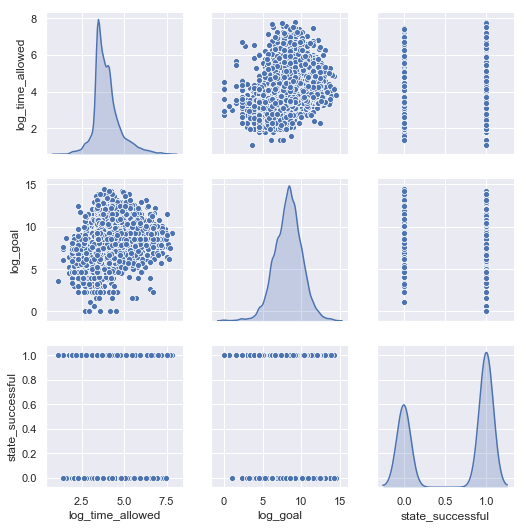

In [73]:
# Plot pair relationships
sns.set(rc={'figure.figsize':(30,15)})
sns.pairplot(pd.concat([X_c,y],1), diag_kind="kde", height=2.5)
#plt.savefig('plot_downloads/pairplots.png')


In [74]:
(pd.concat([X_c,y],1)).corr()

,log_time_allowed,log_goal,state_successful
log_time_allowed,1.000000,0.251105,0.030201
log_goal,0.251105,1.000000,-0.228176
state_successful,0.030201,-0.228176,1.000000


# 3.0 Modelling

The following models will be used:
   - Logistic regression
   - Random forest
   - XGBoost

### 3.1 Split, Train, Test

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 3.2 Random Forest

In [77]:
forest_vanilla = RandomForestClassifier()
forest_vanilla.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
y_hat_train_v_rf = forest_vanilla.predict(X_train)
y_hat_test_v_rf = forest_vanilla.predict(X_test)
accuracy_score(y_train, y_hat_train_v_rf), accuracy_score(y_test, y_hat_test_v_rf)

(0.9879993142465284, 0.7481007596961216)

In [79]:
print(confusion_matrix(y_train, y_hat_train_v_rf))

[[2192   22]
 [  48 3571]]


In [80]:
print(confusion_matrix(y_test, y_hat_test_v_rf))

[[ 640  306]
 [ 324 1231]]


Normalized confusion matrix
[[0.67653277 0.32346723]
 [0.20836013 0.79163987]]


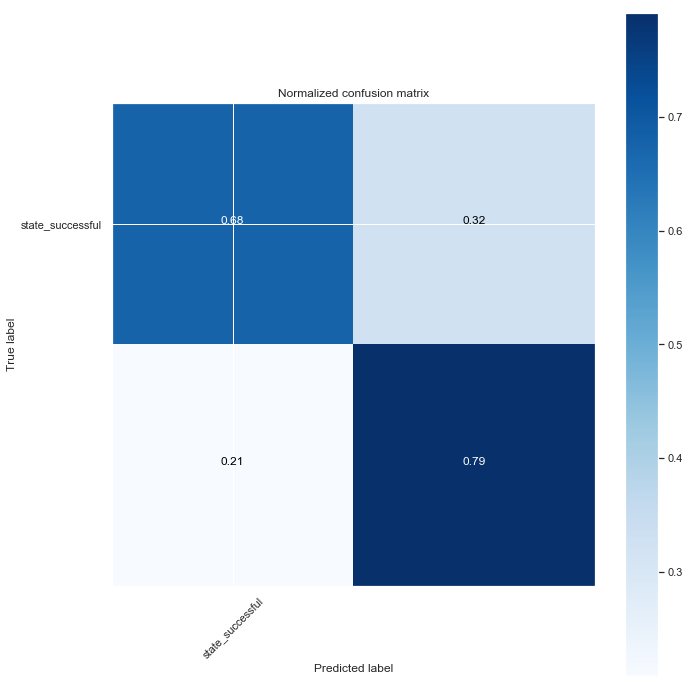

In [81]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(y_test, y_hat_test_v_rf), classes=set(y), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# hyperparameter tuning 

In [82]:
# varying number of max_depth parameter and setting criterion='entropy'
array32 = list(range(1,100))
clf_list = []
for i in array32:
    clf_choc = RandomForestClassifier(criterion='entropy', max_depth=i);  # Train the classifier using training data 
    clf_list.append(clf_choc.fit(X_train, y_train))
auc_list_train = []
for i in clf_list:
    y_pred = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
    auc_list_train.append(auc(false_positive_rate, true_positive_rate))
auc_list_test = []
for i in clf_list:
    y_pred1 = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
    auc_list_test.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

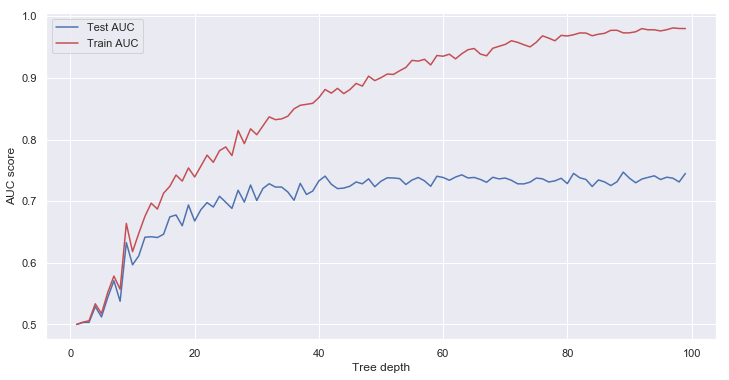

<Figure size 2160x1080 with 0 Axes>

In [93]:
plt.figure(figsize=(12,6))
plt.plot(array32, auc_list_test, 'b', label='Test AUC')
plt.plot(array32, auc_list_train, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()
# plt.savefig('plot_downloads/AUCvsTreeDepth.png')

In [84]:
# varying number of min_samples_split parameter and setting criterion='entropy'
array1 = list(map(lambda x: round(x,1), np.arange(0.1,1.0,0.1)))
clf_list_strawberry = []
for i in array1:
    clf_strawberry = RandomForestClassifier(criterion='entropy', min_samples_split = i)  # Train the classifier using training data 
    clf_list_strawberry.append(clf_strawberry.fit(X_train, y_train))
auc_list_test_strawberry = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_strawberry.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_strawberry = []
for i in clf_list_strawberry:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_strawberry.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

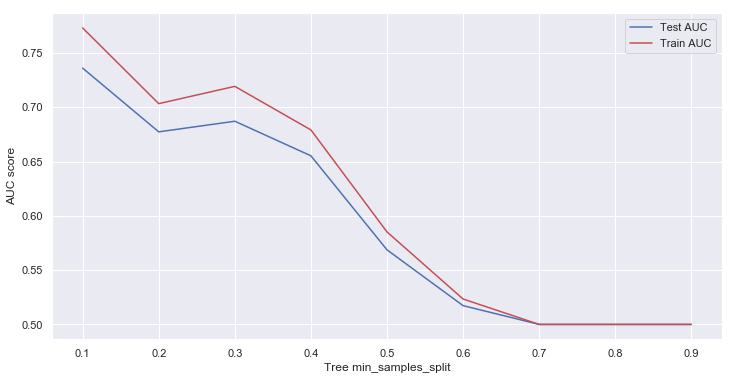

<Figure size 2160x1080 with 0 Axes>

In [94]:
plt.figure(figsize=(12,6))
plt.plot(array1, auc_list_test_strawberry, 'b', label='Test AUC')
plt.plot(array1, auc_list_train_strawberry, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree min_samples_split')
plt.legend()
plt.show()
#plt.savefig('plot_downloads/AUCvsmin_samples.png')

In [95]:
# varying number of min_samples_leaf parameter and setting criterion='entropy'
array05 = list(map(lambda x: round(x,1), np.arange(0.1,0.5,0.1)))
clf_list_cookiencream = []
for i in array05:
    clf_cookiencream = RandomForestClassifier(criterion='entropy', min_samples_leaf = i)  # Train the classifier using training data 
    clf_list_cookiencream.append(clf_cookiencream.fit(X_train, y_train))
auc_list_test_cookiencream = []
for i in clf_list_cookiencream:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_cookiencream.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_cookiencream = []
for i in clf_list_cookiencream:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_cookiencream.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

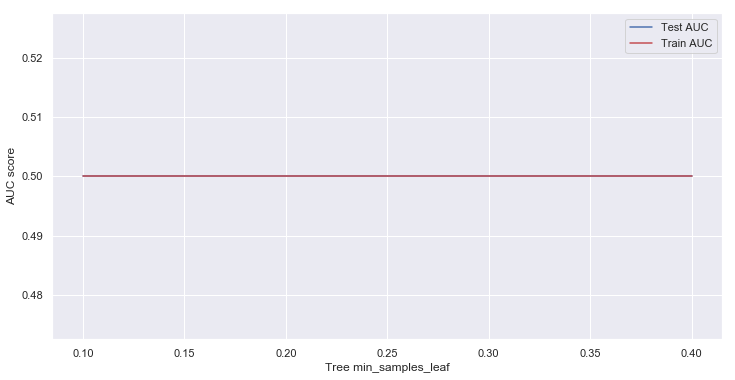

In [96]:
plt.figure(figsize=(12,6))
plt.plot(array05, auc_list_test_cookiencream, 'b', label='Test AUC')
plt.plot(array05, auc_list_train_cookiencream, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree min_samples_leaf')
plt.legend()
plt.show()

In [97]:
# varying number of max_features parameter and setting criterion='entropy'
array200 = range(1,int(len(X.columns)/2))
clf_list_peanutbutter = []
for i in array200:
    clf_peanutbutter = RandomForestClassifier(criterion='entropy', max_features = i)  # Train the classifier using training data 
    clf_list_peanutbutter.append(clf_peanutbutter.fit(X_train, y_train))
auc_list_test_peanutbutter = []
for i in clf_list_peanutbutter:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_peanutbutter.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_peanutbutter = []
for i in clf_list_peanutbutter:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_peanutbutter.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

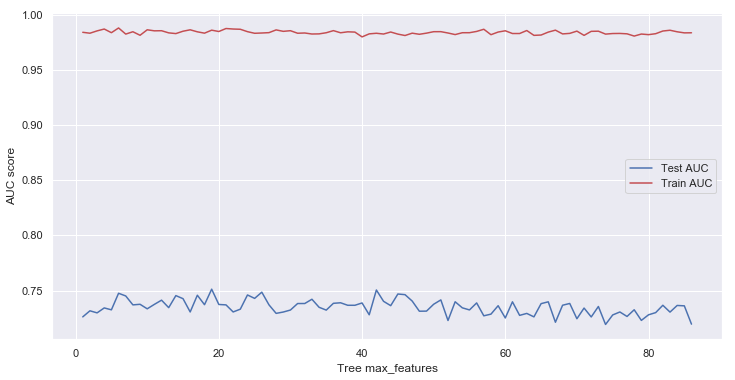

In [98]:
plt.figure(figsize=(12,6))
plt.plot(array200, auc_list_test_peanutbutter, 'b', label='Test AUC')
plt.plot(array200, auc_list_train_peanutbutter, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree max_features')
plt.legend()
plt.show()

In [128]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=69, min_samples_split =0.2)
clf_rf.fit(X_train, y_train)
y_hat_rf_train = clf_rf.predict(X_train)
y_hat_rf_test = clf_rf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_rf_test)
auc(false_positive_rate, true_positive_rate)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6876508296907609

In [102]:
round(accuracy_score(y_train, y_hat_rf_train)*100,1), round(accuracy_score(y_test, y_hat_rf_test)*100,1)


(77.2, 75.0)

In [103]:
# very slight imporvement to Vanilla on test
print(confusion_matrix(y_test, y_hat_test_v_rf))

[[ 640  306]
 [ 324 1231]]


In [129]:
# dot_data = StringIO()
# export_graphviz(clf_rf.fit(X_train, y_train), out_file=dot_data,  
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### 3.3 Logistic Regression

In [104]:
logreg_vanilla = LogisticRegression()
model_log = logreg_vanilla.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
y_score_lr_v = logreg_vanilla.decision_function(X_test)
y_hat_test_lr_v = logreg_vanilla.predict(X_test)
y_hat_train_lr_v = logreg_vanilla.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_test, y_score_lr_v)

In [106]:
print('AUC: {}'.format(auc(fpr, tpr)))
print(confusion_matrix(y_train, y_hat_train_lr_v))
print(confusion_matrix(y_test, y_hat_test_lr_v))


AUC: 0.8565454137577071
[[1664  550]
 [ 576 3043]]
[[ 660  286]
 [ 287 1268]]


In [107]:
# accuracy enhanced slightly when compared to RandomForest
round(accuracy_score(y_train, y_hat_train_lr_v)*100,1), round(accuracy_score(y_test, y_hat_test_lr_v)*100,1)

(80.7, 77.1)

In [108]:
# accuracy enhanced slightly when compared to RandomForest
round(accuracy_score(y_train, y_hat_train_lr_v)*100,1), round(accuracy_score(y_test, y_hat_test_lr_v)*100,1)

(80.7, 77.1)

AUC: 0.8565454137577071


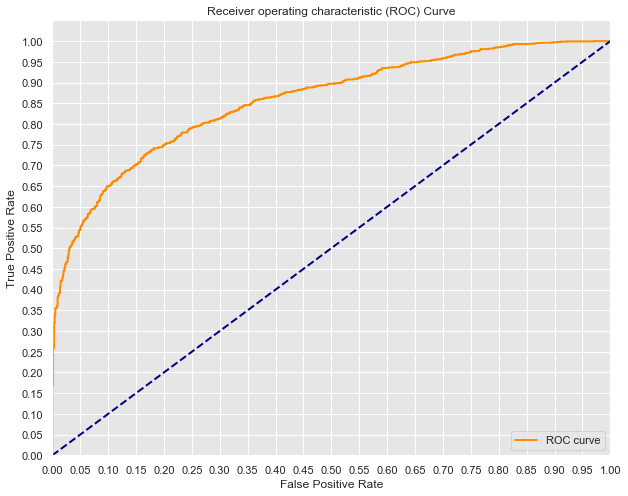

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [110]:
# hyperparameter tuing

In [111]:
# Change C parameter
C_param_range = [0.001,0.01,0.1,1,10,100]
clf_list = []
for i in C_param_range:
    clf_choc = LogisticRegression(C=i);  # Train the classifier using training data 
    clf_list.append(clf_choc.fit(X_train, y_train))
auc_list_train_lr_choc = []
for i in clf_list:
    y_pred = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
    auc_list_train_lr_choc.append(auc(false_positive_rate, true_positive_rate))
auc_list_test_lr_choc = []
for i in clf_list:
    y_pred1 = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
    auc_list_test_lr_choc.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, w

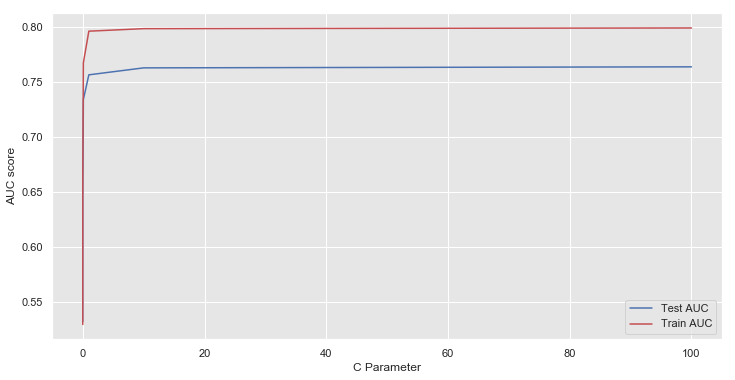

In [112]:
plt.figure(figsize=(12,6))
plt.plot(C_param_range, auc_list_test_lr_choc, 'b', label='Test AUC')
plt.plot(C_param_range, auc_list_train_lr_choc, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('C Parameter')
plt.legend()
plt.show()

In [113]:
# Change penlty and corresponding solver type
penalty_list = {'l1':'liblinear', 'l2':'liblinear', 'none':'lbfgs'}
clf_list_strawberry = []
for k,v in penalty_list.items():
    print(k,v)
    clf_strawberry = LogisticRegression(penalty = k,solver=v)  # Train the classifier using training data 
    clf_list_strawberry.append(clf_strawberry.fit(X_train, y_train))
auc_list_test_strawberry_lr = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_strawberry_lr.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_strawberry_lr = []
for i in clf_list_strawberry:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_strawberry_lr.append(auc(false_positive_rate, true_positive_rate))

l1 liblinear
l2 liblinear


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


none lbfgs


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [114]:
auc_list_test_strawberry_lr, auc_list_train_strawberry_lr

([0.7603243985506754, 0.7565542511029687, 0.7583026858731637],
 [0.7943107028472882, 0.7962104300973009, 0.7987291303326591])

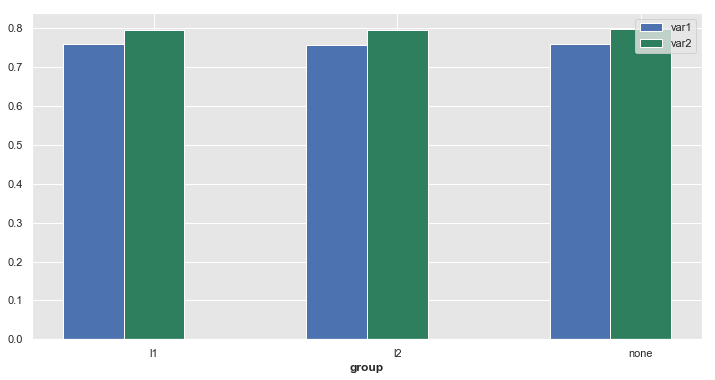

In [115]:
# set width of bar
plt.figure(figsize=(12,6))
barWidth = 0.25
 
# set height of bar
bars1 = auc_list_test_strawberry_lr
bars2 = auc_list_train_strawberry_lr
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#2d7f5e', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(penalty_list.keys()))
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [116]:
logreg_ = LogisticRegression(penalty='l1', solver='liblinear')
model_log = logreg_.fit(X_train, y_train)

y_score_lr = logreg_.decision_function(X_test)
y_hat_test_lr = logreg_.predict(X_test)
y_hat_train_lr = logreg_.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_test, y_score_lr)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [117]:
print('AUC: {}'.format(auc(fpr, tpr)))
print(confusion_matrix(y_train, y_hat_train_lr))
print(confusion_matrix(y_test, y_hat_test_lr))


AUC: 0.8575246595922585
[[1677  537]
 [ 611 3008]]
[[ 672  274]
 [ 294 1261]]


In [118]:
print('validation: '+str(round(accuracy_score(y_train, y_hat_train_lr)*100,1))+'%. Test: '+str(round(accuracy_score(y_test, y_hat_test_lr)*100,1))+'%.')

validation: 80.3%. Test: 77.3%.


AUC: 0.8575246595922585


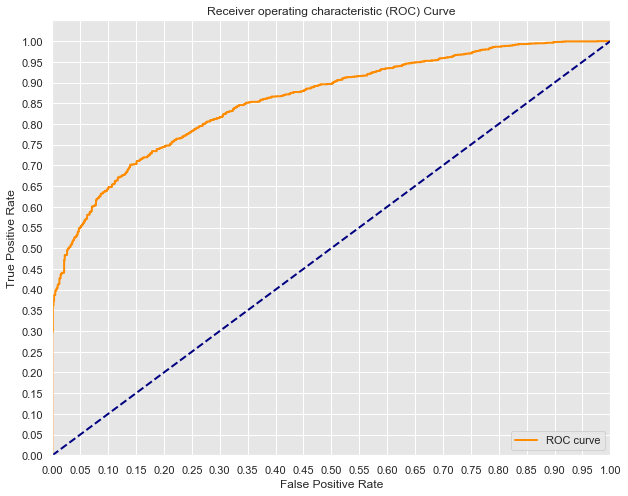

<Figure size 432x288 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('plot_downloads/ROCcurve_logreg.png')

Normalized confusion matrix
[[0.71035941 0.28964059]
 [0.18906752 0.81093248]]


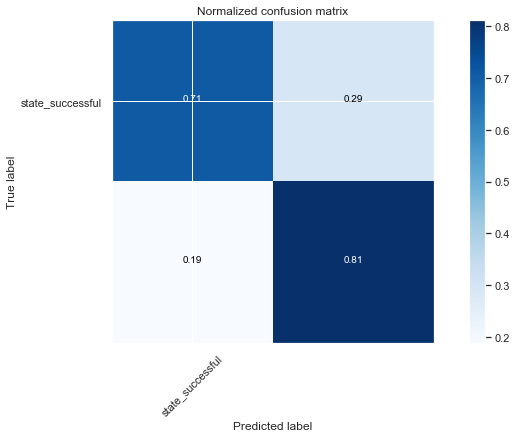

<Figure size 432x288 with 0 Axes>

In [122]:
plt.figure(figsize=(10,6))
plot_confusion_matrix(confusion_matrix(y_test, y_hat_test_lr), classes=set(y), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
# plt.savefig('plot_downloads/confmatrix_logeg.png')

In [ ]:
# Little difference - keep as Vanilla

### 3.4 XGBoost

In [ ]:
XGBoost = xgb.XGBClassifier()
XGBoost.fit(X_train, y_train)
y_hat_train_XG_v = XGBoost.predict(X_train)
y_hat_test_XG_v = XGBoost.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
# param_grid = {
#     "learning_rate": [0.1,0.15,0.2,0.25],
#     'max_depth': [4,6,8,10],
#     'min_child_weight': [5,10,15,20],
#     'subsample': [0.5,0.6,0.7,0.8],
#     'n_estimators': [5, 30, 100, 250],
# }
param_grid_XG = {
    "learning_rate": [0.1,0.2],
    'max_depth': [20,30,60],
    'min_child_weight': [10,20],
    'subsample': [0.5,0.7],
}

In [ ]:
grid_clf = GridSearchCV(XGBoost, param_grid_XG, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train_XG = grid_clf.predict(X_train)
y_hat_test_XG = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train_XG)
val_accuracy = accuracy_score(y_test, y_hat_test_XG)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
print(confusion_matrix(y_train, y_hat_train_XG))
print(confusion_matrix(y_test, y_hat_test_XG))

In [ ]:
# Grid Search found the following optimal parameters: 
# learning_rate: 0.1
# max_depth: 20  
# min_child_weight: 10
# subsample: 0.7


### 3.5 Baseline Model

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
DC = DummyClassifier(strategy='most_frequent')

In [ ]:
DC.fit(X_train,y_train)

In [ ]:
DC.predict(X_test)

In [ ]:
accuracy_score(y_test, DC.predict(X_test))

In [ ]:
def summary(y_test,y_hat_te,y_train,y_hat_tr):
    print('Accuracy Score- Training Model: '+str(round(accuracy_score(y_train, y_hat_tr)*100,1))+'%. Model on testing data: '+str(round(accuracy_score(y_test, y_hat_te)*100,1))+'%.')
    print('Recall Score- Training Model: '+str(round(recall_score(y_train, y_hat_tr)*100,1))+'%. Model on testing data: '+str(round(recall_score(y_test, y_hat_te)*100,1))+'%.')
    print('Precision score - Training Model: '+str(round(precision_score(y_train, y_hat_tr)*100,1))+'%. Model on testing data: '+str(round(precision_score(y_test, y_hat_te)*100,1))+'%.')
    print('F1 score - Training Model: '+str(round(f1_score(y_train, y_hat_tr)*100,1))+'%. Model on testing data: '+str(round(f1_score(y_test, y_hat_te)*100,1))+'%.')

# 4.0 Summary of each model evaluation parameters

Logestic Regression Vanilla Model returns best result with a very small margin. I will inspect the False Postives and Negatives from the model in the next section. See summary of accuracy results below.

In [ ]:
# Random Forest Vanilla
summary(y_test, y_hat_test_v_rf,y_train, y_hat_train_v_rf)

In [ ]:
# Random Forest Hyper-Optimised
summary(y_test, y_hat_rf_test,y_train, y_hat_rf_train)

In [ ]:
# Logistic Regression Vanilla
summary(y_test, y_hat_test_lr_v, y_train, y_hat_train_lr_v)

In [ ]:
# Logistic Regression Hyper-Opstimised
summary(y_test, y_hat_test_lr, y_train, y_hat_train_lr)

In [ ]:
#XGBoost Vanilla
summary(y_test, y_hat_test_XG_v, y_train, y_hat_train_XG_v)

In [ ]:
#XGBoost with Tuning
summary(y_test, y_hat_test_XG, y_train, y_hat_train_XG)

# 5.0 FP and FN Inspection

In [ ]:
trian_df = pd.DataFrame(index=y_train.index)

In [ ]:
trian_df['y_train'] = y_train['state_successful']

In [ ]:
# prediction results from Logistic Regression Vanilla Model
trian_df['y_train_pred'] = y_hat_train_lr_v

In [ ]:
trian_df.head(2)

In [ ]:
# checking confusion matrix results matching one done previously
confusion_matrix(trian_df['y_train'], trian_df['y_train_pred'])

In [ ]:
# false positives stored below
false_pos = trian_df[(trian_df.y_train == 0) & (trian_df.y_train_pred == 1)]

In [ ]:
false_pos.head(2)

In [ ]:
false_pos_df = false_pos.join(df, how='inner')

In [ ]:
false_pos_df.groupby(['country', 'cat_slug']).agg({'goal':'mean','time_allowed':'mean'});

In [ ]:
false_pos_df.head(2)

In [ ]:
false_pos_df.describe()

In [ ]:
false_neg = trian_df[(trian_df.y_train == 1) & (trian_df.y_train_pred == 0)]
false_neg_df = false_pos.join(df, how='inner')
false_neg_df.head(1)

In [ ]:
false_neg_df.groupby(['country', 'cat_slug']).agg({'goal':'mean','time_allowed':'mean'});

In [ ]:
# inspect and explain
# label figures 

# 6.0 Unseen Data Test

In [ ]:
df4['deadline'] = pd.to_datetime(df4['deadline'], unit='ms')
df4['deadline'] = pd.to_datetime(df4['deadline'].dt.date)
indexNames = df4[(df4['state'] == 'canceled')|(df4['state'] == 'live')|(df4['state'] == 'suspended')].index
df4.drop(indexNames,0,inplace=True)
df4.reset_index(drop=True, inplace=True)
for index, row in df4.iterrows():
    if df4.loc[index,'country'] == 'US' or df4.loc[index,'country'] == 'CA':
        df4.loc[index,'country'] = 'NAmerica'
    elif df4.loc[index,'country'] == 'NZ' or df4.loc[index,'country'] == 'AU':
        df4.loc[index,'country'] = 'Aus'
    elif df4.loc[index,'country'] == 'JP' or df4.loc[index,'country'] == 'CH' or df4.loc[index,'country'] == 'HK' or df4.loc[index,'country'] == 'SG':
        df4.loc[index,'country'] = 'Aisa'
    elif df4.loc[index,'country'] == 'MX':
        df4.loc[index,'country'] = 'CAmerica'
    else:
        df4.loc[index,'country'] = 'Euro'
df4['time_allowed'] = df4['deadline']-df4['created_at']
df4.time_allowed = df4.time_allowed.dt.days
df4 = df4[(df4['time_allowed'] < 5000) & (df4['goal'] < 2e6)]
df4['log_goal'] = np.log(df4['goal'])
df4['log_time_allowed'] = np.log(df4['time_allowed'])
df4.reset_index(drop=True, inplace=True)

In [ ]:
X_c_4 = df4[['log_time_allowed', 'log_goal']]
X_d_4 = pd.get_dummies(df4[['cat_slug', 'staff_pick', 'country']], drop_first=True, prefix_sep='_')

In [ ]:
X_4 = pd.concat([X_c_4,X_d_4],1)
y_4 = pd.get_dummies(df4[['state']], drop_first=True)

In [ ]:
X_4.columns

In [ ]:
X_4.shape

In [ ]:
 X_4.isna().sum().sum()

In [ ]:
y_hat_df_unseen = logreg_.predict(X_4)

###### summary(y_4, y_hat_df_unseen, y_train, y_hat_df_lr_)